In [1]:
from scipy import signal
from scipy.ndimage import gaussian_filter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
seed: int = 0
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
# Create dataframe with a date range (4 years).
date_range = pd.date_range(start="2017-01-01", end="2020-12-31", freq="D")
# Create data frame.
df = pd.DataFrame(data={"date": date_range})
# Extract number of points.
n = df.shape[0]

In [4]:
df["y"] = rng.normal(loc=0.0, scale=0.5, size=n)

In [5]:
# External regressor:
df["x"] = rng.uniform(low=0.0, high=1.0, size=n)
df["x"] = df["x"].apply(lambda x: x if abs(x) > 0.95 else 0.0)

df["y"] = df["y"] + 6 * df["x"]

In [6]:
df["x"] = df["x"].astype(np.float32)
df["y"] = df["y"].astype(np.float32)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1461 non-null   datetime64[ns]
 1   y       1461 non-null   float32       
 2   x       1461 non-null   float32       
dtypes: datetime64[ns](1), float32(2)
memory usage: 23.0 KB


In [7]:
df["y"] = df["y"] + np.power(df.index.values, 1 / 3)

In [8]:
# Seasonal features:
df["day_of_month"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["day_of_week"] = df["date"].dt.dayofweek
df["daysinmonth"] = df["date"].dt.daysinmonth


df["y"] = (
    df["y"]
    + 2 * np.cos(2 * np.pi * df["month"] / 12)
    + 0.5 * np.sin(2 * np.pi * df["month"] / 12)
    + 1.5 * np.cos(2 * np.pi * df["day_of_week"] / 7)
    + 2 * np.sin(2 * np.pi * df["day_of_month"] / df["daysinmonth"])
)

df["y"] = df["y"].bfill().astype(np.float32)

df.head(10)

,date,y,x,day_of_month,month,day_of_week,daysinmonth
0,2017-01-01,3.382748,0.000000,1,1,6,31
1,2017-01-02,5.204710,0.000000,2,1,0,31
2,2017-01-03,5.639954,0.000000,3,1,1,31
3,2017-01-04,10.412126,0.969928,4,1,2,31
4,2017-01-05,3.647452,0.000000,5,1,3,31
5,2017-01-06,4.396875,0.000000,6,1,4,31
6,2017-01-07,6.094326,0.000000,7,1,5,31
7,2017-01-08,7.301190,0.000000,8,1,6,31
8,2017-01-09,7.066338,0.000000,9,1,0,31
9,2017-01-10,6.160268,0.000000,10,1,1,31


[Text(0.5, 1.0, 'Dependent Variable')]

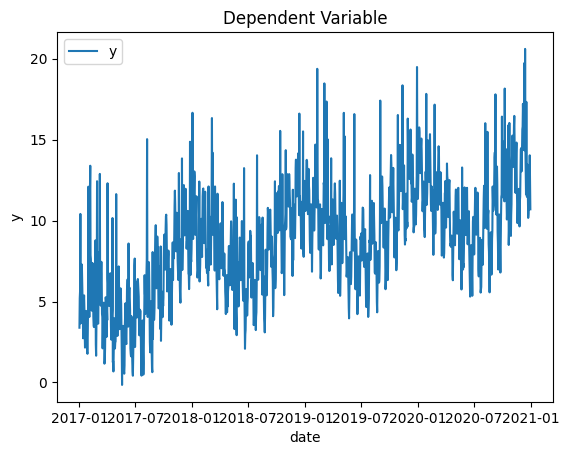

In [9]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", label="y", data=df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Dependent Variable")

In [10]:
threshold_date = pd.to_datetime("2020-07-01")
mask = df["date"] < threshold_date

df_train = df[mask]
df_test = df[~mask]

[Text(0.5, 1.0, 'Dependent Variable')]

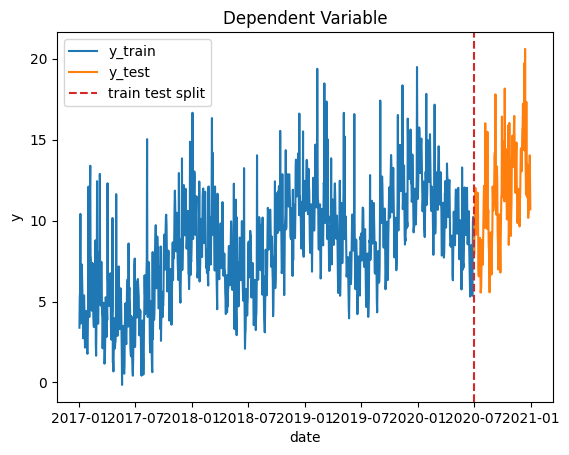

In [11]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", label="y_train", data=df_train, ax=ax)
sns.lineplot(x="date", y="y", label="y_test", data=df_test, ax=ax)
ax.axvline(threshold_date, color="C3", linestyle="--", label="train test split")
ax.legend(loc="upper left")
ax.set(title="Dependent Variable")

In [12]:
# Local linear trend.
local_linear_trend = tfp.sts.LocalLinearTrend(
    observed_time_series=df_train["y"],
    name="local_linear_trend",
)

# We need to pre-define the number of days in each month.
num_days_per_month = np.array(
    [
        [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
        [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
        [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
        [31, 29, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],  # year with leap day.
    ]
)

# Define month of year seasonal variable.
month_of_year = tfp.sts.Seasonal(
    num_seasons=12, num_steps_per_season=num_days_per_month, name="month_of_year"
)

# Define day of week as seasonal variable.
day_of_week = tfp.sts.Seasonal(
    num_seasons=7,
    num_steps_per_season=1,
    observed_time_series=df_train["y"],
    name="day_of_week",
)

# Create cyclic variable for day of the month.
design_matrix_day_of_month = tf.reshape(
    np.sin(2 * np.pi * df["day_of_month"] / df["daysinmonth"]).values.astype(
        np.float32
    ),
    (-1, 1),
)

# Define day of the month as an external regressor.
# We do not encode it as seasonal as the number of steps is not uniform.
day_of_month = tfp.sts.LinearRegression(
    design_matrix=design_matrix_day_of_month, name="day_of_month"
)

# Define external regressor component.
# We use the whole data set (df) as we expect to have these values in the future.
design_matrix_x_var = tf.reshape(df["x"].values, (-1, 1))

x_var = tfp.sts.LinearRegression(design_matrix=design_matrix_x_var, name="x_var")

In [13]:
design_matrix_day_of_month.shape

TensorShape([1461, 1])

In [14]:
model_components = [
    local_linear_trend,
    month_of_year,
    day_of_week,
    day_of_month,
    x_var,
]

toy_model = tfp.sts.Sum(components=model_components, observed_time_series=df_train["y"])

In [15]:
for p in toy_model.parameters:
    print("-" * 140)
    print(f"Parameter: {p.name}")
    print(f"Prior: {str(p.prior)}")

--------------------------------------------------------------------------------------------------------------------------------------------
Parameter: observation_noise_scale
Prior: tfp.distributions.LogNormal("LogNormal", batch_shape=[], event_shape=[], dtype=float32)
--------------------------------------------------------------------------------------------------------------------------------------------
Parameter: local_linear_trend/_level_scale
Prior: tfp.distributions.LogNormal("level_scale_prior", batch_shape=[], event_shape=[], dtype=float32)
--------------------------------------------------------------------------------------------------------------------------------------------
Parameter: local_linear_trend/_slope_scale
Prior: tfp.distributions.LogNormal("slope_scale_prior", batch_shape=[], event_shape=[], dtype=float32)
--------------------------------------------------------------------------------------------------------------------------------------------
Parameter: mon

In [16]:
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=toy_model, seed=seed
)

In [17]:
q_prior_samples = variational_posteriors.sample(1000)

In [18]:
num_variational_steps = 500

# Set optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.1)


# Using fit_surrogate_posterior to build and optimize
# the variational loss function.
@tf.function(experimental_compile=True)
def train():
    # Build the joint density.
    target_log_prob_fn = toy_model.joint_distribution(
        observed_time_series=df_train["y"]
    ).log_prob

    return tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=target_log_prob_fn,
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps,
        seed=seed,
    )


# Run optimization.
elbo_loss_curve = train()

[Text(0.5, 1.0, 'ELBO Loss Curve'), Text(0.5, 0, 'iteration')]

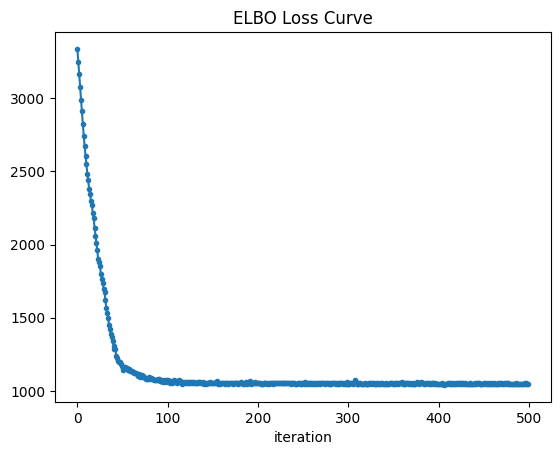

In [19]:
fig, ax = plt.subplots()
ax.plot(elbo_loss_curve, marker=".")
ax.set(title="ELBO Loss Curve", xlabel="iteration")

In [20]:
q_samples = variational_posteriors.sample(2_000)

In [21]:
num_days_per_month[-1][6:13].sum().astype(np.int32)

184

In [22]:
# Compute number of days in the last 6 months of 2020.
# forecast_window = num_days_per_month[-1][6:13].sum().astype(np.int32)
forecast_window = 1840
# Get forecast distribution.
forecast_dist = tfp.sts.forecast(
    model=toy_model,
    observed_time_series=df_train["y"],
    parameter_samples=q_samples,
    num_steps_forecast=forecast_window,
)

In [23]:
# num_samples = 1_000
num_samples = 1_0

forecast_mean, forecast_scale, forecast_samples = (
    forecast_dist.mean().numpy().flatten(),
    forecast_dist.stddev().numpy().flatten(),
    forecast_dist.sample(num_samples).numpy().flatten(),
)

InvalidArgumentError: Graph execution error:

Detected at node AdditiveStateSpaceModel/mean/AdditiveStateSpaceModel/mean_joint/scan/while/GatherV2 defined at (most recent call last):
  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 982, in launch_instance

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 712, in start

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 499, in process_one

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 730, in execute_request

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 383, in do_execute

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 528, in run_cell

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes

  File "C:\Users\Alaric\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code

  File "C:\Users\Alaric\AppData\Local\Temp\ipykernel_15256\362167805.py", line 5, in <module>

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_probability\python\distributions\distribution.py", line 1536, in mean

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_probability\python\distributions\mixture_same_family.py", line 356, in _mean

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_probability\python\distributions\distribution.py", line 1536, in mean

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_probability\python\distributions\linear_gaussian_ssm.py", line 1221, in _mean

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_probability\python\distributions\linear_gaussian_ssm.py", line 1259, in _joint_mean

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_probability\python\distributions\linear_gaussian_ssm.py", line 1913, in mean_step

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_probability\python\sts\components\sum.py", line 311, in observation_noise_fn

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_probability\python\sts\components\sum.py", line 312, in <genexpr>

  File "c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_probability\python\sts\components\regression.py", line 49, in observation_noise_fn

indices = 1461 is not in [0, 1461)
	 [[{{node AdditiveStateSpaceModel/mean/AdditiveStateSpaceModel/mean_joint/scan/while/GatherV2}}]] [Op:__inference_mean_44382]

In [ ]:
forecast_mean

array([ 8.882614 ,  8.247744 ,  8.522177 ,  9.90793  , 11.371819 ,
       12.137704 , 11.625121 , 10.431537 ,  9.366279 ,  9.1651325],
      dtype=float32)

In [ ]:
df_test = df_test.assign(
    y_pred=forecast_mean,
    y_pred_std=forecast_scale,
    errors=lambda x: x["y"] - x["y_pred"],
)

ValueError: Length of values (10) does not match length of index (184)

[Text(0.5, 1.0, 'STS Forecast')]

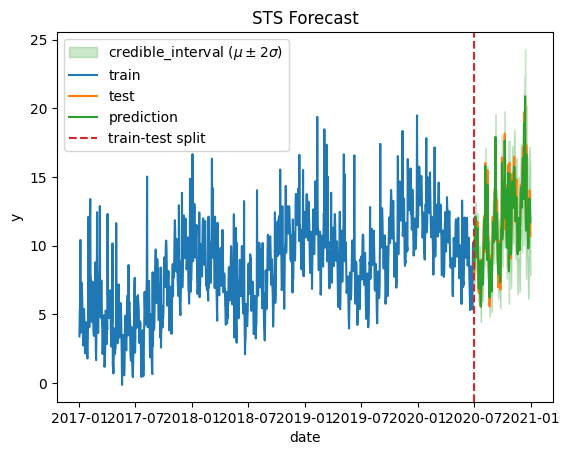

In [ ]:
fig, ax = plt.subplots()

ax.fill_between(
    x=df_test["date"],
    y1=df_test["y_pred"] - 2 * df_test["y_pred_std"],
    y2=df_test["y_pred"] + 2 * df_test["y_pred_std"],
    color="C2",
    alpha=0.25,
    label=r"credible_interval ($\mu \pm 2\sigma$)",
)

sns.lineplot(x="date", y="y", label="train", data=df_train, ax=ax)
sns.lineplot(x="date", y="y", label="test", data=df_test, ax=ax)
sns.lineplot(x="date", y="y_pred", label="prediction", data=df_test, ax=ax)
ax.axvline(x=threshold_date, color="C3", linestyle="--", label="train-test split")
ax.legend(loc="upper left")
ax.set(title="STS Forecast")